In [127]:
# Data Wrangling
import numpy as np
import pandas as pd

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot, prediction_error

# Pipilines para tratar dados futuros
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Seleção e validação de modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Pré-processamento para incluir no Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Modelos
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import  LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Manter saída do processamento do sklearn como DataFrame pandas
from sklearn import set_config
set_config(transform_output='pandas')

# Salvar modelo
import pickle

In [76]:
# Definindo função para retirar as metricas
def get_metrics(y_true, y_pred):
    dict_metrics = {
        'R2' : metrics.r2_score(y_true, y_pred),
        'MAE' : metrics.mean_absolute_error(y_true, y_pred),
        'MAPE' : metrics.mean_absolute_percentage_error(y_true, y_pred),
        'RMSE' : np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    }
    return dict_metrics

In [77]:
# Dataset
df = pd.read_csv('insurance.csv')
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [78]:
# Descrição dos dados
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [79]:
# Infos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


<Axes: xlabel='bmi', ylabel='charges'>

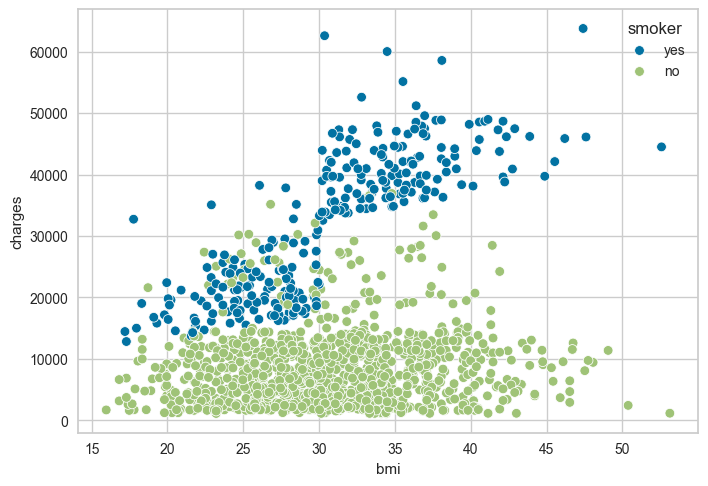

In [80]:
# Plot fumantes
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')

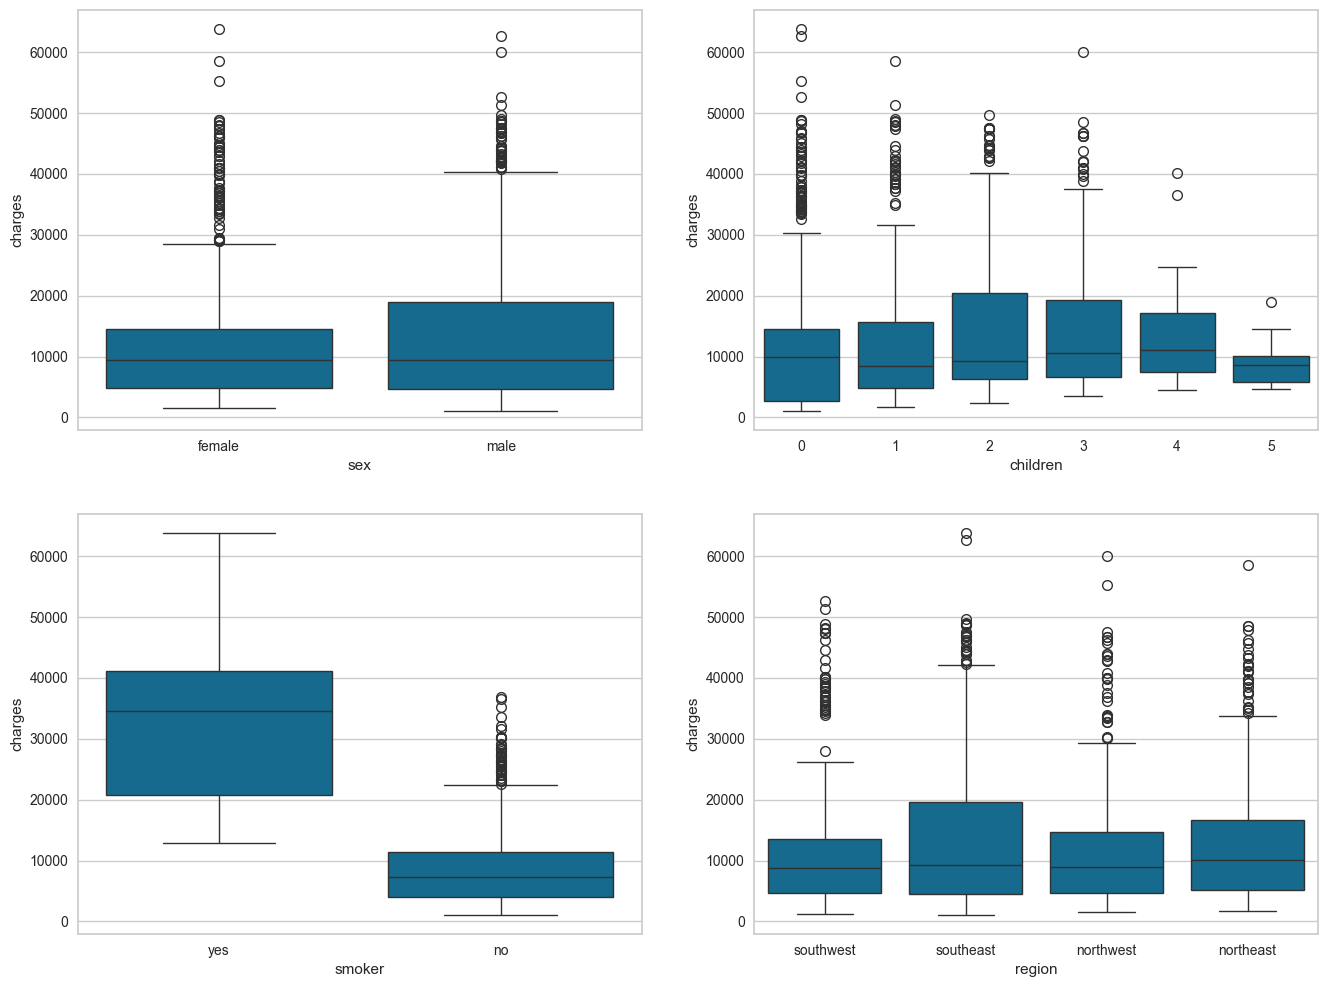

In [81]:
# Boxplot de separação geral das colunas
cat_plot_cols = ['sex', 'children', 'smoker', 'region']

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
for col, ax in zip(cat_plot_cols, axes.flatten()):
    sns.boxplot(x=col, y='charges', data=df, ax=ax)

<Axes: >

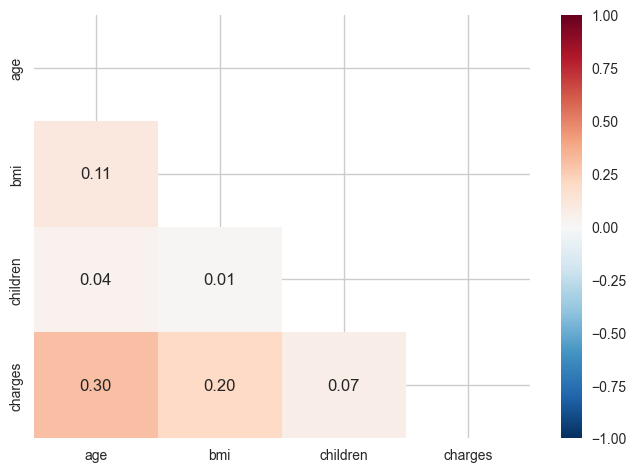

In [82]:
# Verificando correlação 
dfc =df.corr(numeric_only=True)

mask =np.zeros(dfc.shape).astype(bool)
mask[np.triu_indices_from(mask)] = True  # A mascara é apra tirar os centros do resultado de correlação

sns.heatmap(dfc, annot=True, fmt='.2f', center=0, vmax=1, vmin=-1, cmap='RdBu_r', mask = mask)

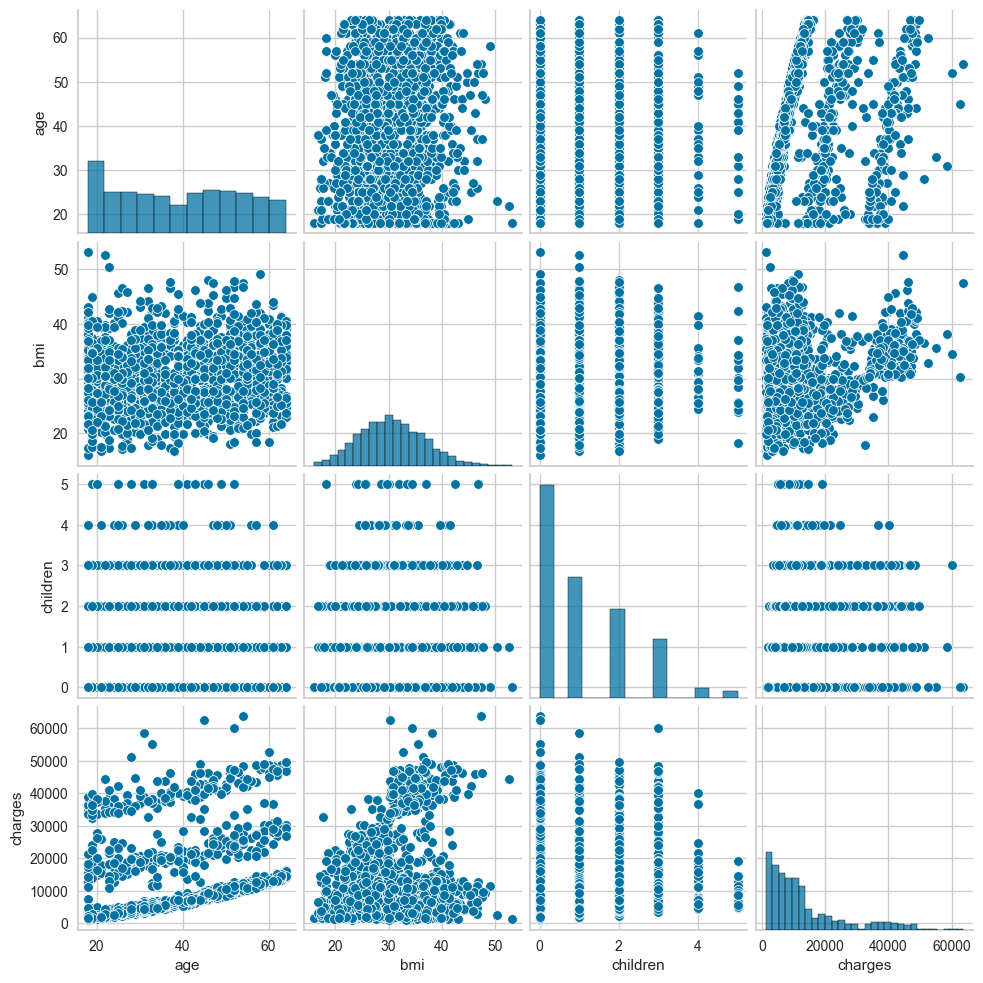

In [83]:
# Pairplot
sns.pairplot(df)

Modeling

In [84]:
# Separando features numericas de categoricas e definindo o targert
NUMERICAL_FEATURES = ['age', 'bmi', 'children']
CATEGORICAL_FEATURES = ['sex', 'smoker', 'region']

FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES
TARGET = 'charges'

In [96]:
# Base de Treino
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

In [120]:
# Def preprocessor
numerical_transfomer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transfomer = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, NUMERICAL_FEATURES),
    ('cat', categorical_transformer, CATEGORICAL_FEATURES)
]).set_output(transform='pandas')

preprocessor.fit_transform(X_train).head(1)

,num__age,num__bmi,num__children,cat__smoker_yes
1068,0.978261,0.153349,0.2,0.0


In [87]:
# Def model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DummyRegressor())
])
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model', DummyRegressor())])

In [88]:
# Def parametros
params = {
    'model' :[
        DummyRegressor(),
        LinearRegression(),
        LassoCV(),
        RidgeCV(),
        RandomForestRegressor(random_state=2023),
        GradientBoostingRegressor(random_state=2023)
    ]
}

# Criando grid_model
grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', verbose=1)
grid_model.fit(X_train,y_train);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [89]:
# Utilizando o grid_model para verificar o melhor estimador
grid_model.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model', GradientBoostingRegressor(random_state=2023))])

In [90]:
# verificando o resultado com um DF
df_cv_results =pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_score') #grid_model.cv_results_
df_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.158039,0.002065,0.008512,0.000508,GradientBoostingRegressor(random_state=2023),{'model': GradientBoostingRegressor(random_sta...,0.857091,0.854775,0.843129,0.840171,0.853438,0.849721,0.006758,1
4,0.660313,0.015669,0.017103,0.000818,RandomForestRegressor(random_state=2023),{'model': RandomForestRegressor(random_state=2...,0.844109,0.848074,0.831330,0.836266,0.844246,0.840805,0.006099,2
2,0.093582,0.001474,0.008291,0.000986,LassoCV(),{'model': LassoCV()},0.758285,0.714893,0.737520,0.752047,0.756104,0.743770,0.016151,3
3,0.014555,0.000825,0.008139,0.000942,RidgeCV(),{'model': RidgeCV()},0.758278,0.714799,0.737557,0.752069,0.756020,0.743745,0.016170,4
1,0.014683,0.000982,0.008916,0.000734,LinearRegression(),{'model': LinearRegression()},0.758224,0.713108,0.737599,0.751764,0.756187,0.743376,0.016760,5
0,0.018524,0.006986,0.010011,0.004319,DummyRegressor(),{'model': DummyRegressor()},-0.002956,-0.000186,-0.000243,-0.000861,-0.000981,-0.001045,0.001007,6


In [91]:
# Ordenando o index para o modelo aparecer primeiro
df_cv_results.loc[:,~df_cv_results.columns.str.contains('splot|time')].set_index('rank_test_score').sort_index()

,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,
1,GradientBoostingRegressor(random_state=2023),{'model': GradientBoostingRegressor(random_sta...,0.857091,0.854775,0.843129,0.840171,0.853438,0.849721,0.006758
2,RandomForestRegressor(random_state=2023),{'model': RandomForestRegressor(random_state=2...,0.844109,0.848074,0.831330,0.836266,0.844246,0.840805,0.006099
3,LassoCV(),{'model': LassoCV()},0.758285,0.714893,0.737520,0.752047,0.756104,0.743770,0.016151
4,RidgeCV(),{'model': RidgeCV()},0.758278,0.714799,0.737557,0.752069,0.756020,0.743745,0.016170
5,LinearRegression(),{'model': LinearRegression()},0.758224,0.713108,0.737599,0.751764,0.756187,0.743376,0.016760
6,DummyRegressor(),{'model': DummyRegressor()},-0.002956,-0.000186,-0.000243,-0.000861,-0.000981,-0.001045,0.001007


In [92]:
# Dado o resultado acima, vamos criar um modelo com GrandientBoosting
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=2023))
])

# Def parametros
params = {
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [300, 400, 500],
    'model__subsample': [1., .8]
}

# Criando grid_model
grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', verbose=1, n_jobs=-1)  
grid_model.fit(X_train,y_train);

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [94]:
# verificando o resultado com um DF
df_cv_results =pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_score') #grid_model.cv_results_
# Ordenando o index para o modelo aparecer primeiro
df_cv_results.loc[:,~df_cv_results.columns.str.contains('splot|time')].set_index('rank_test_score').sort_index().head(3)

,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,
1,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861072,0.861570,0.848556,0.853727,0.865717,0.858128,0.006150
2,0.01,3,500,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861041,0.862363,0.848625,0.851857,0.865180,0.857813,0.006408
3,0.01,3,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.860566,0.859824,0.846292,0.853409,0.865086,0.857035,0.006536


In [97]:
# Pegando o meslhor estimador para test
model_pipeline = grid_model.best_estimator_

# Pred do test
y_pred = model_pipeline.predict(X_test)

# Metrics
get_metrics(y_test, y_pred)

{'R2': 0.8666376387968089,
 'MAE': 2497.122249202784,
 'MAPE': 0.3013239427631112,
 'RMSE': 4190.521276202634}

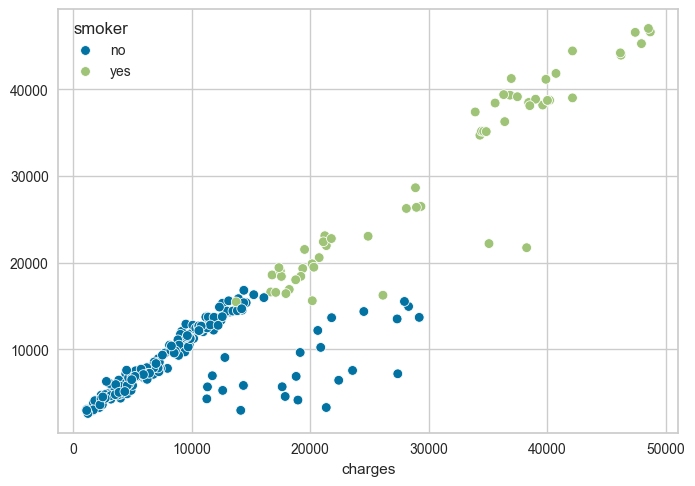

In [99]:
# Scatterplot do modelo
sns.scatterplot(x=y_test, y=y_pred, hue=X_test.smoker);

<Axes: >

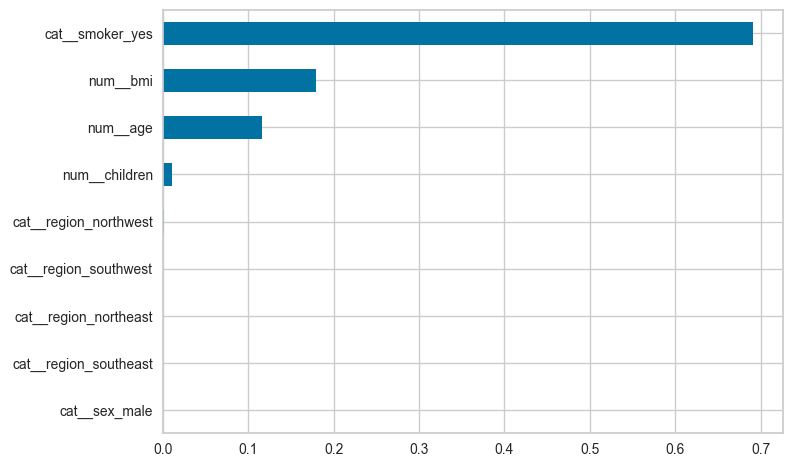

In [118]:
#Plotando series de features e suas importancias
importances = pd.Series(
    data = model_pipeline.named_steps['model'].feature_importances_,
    index = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

importances.sort_values().plot.barh()

DADO OS RESULTADOS DO MODELO, VAMOS REFAZER AS FEATURES PARA CONCLUSÃO

In [119]:
NUMERICAL_FEATURES = ['age', 'bmi', 'children']
CATEGORICAL_FEATURES = ['smoker']

FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES
TARGET = 'charges'

# Base de Treino
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

In [121]:
numerical_transfomer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transfomer = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, NUMERICAL_FEATURES),
    ('cat', categorical_transformer, CATEGORICAL_FEATURES)
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=2023))
])

params = {
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [300, 400, 500],
    'model__subsample': [1., .8]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', verbose=1, n_jobs=-1)  
grid_model.fit(X_train,y_train);

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [122]:
# verificando o resultado com um DF
df_cv_results =pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index() #grid_model.cv_results_
# Ordenando o index para o modelo aparecer primeiro
df_cv_results.loc[:,~df_cv_results.columns.str.contains('splot|time')].head(3)

,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,
1,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861768,0.860509,0.848767,0.855080,0.865357,0.858296,0.005796
2,0.01,3,500,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861557,0.860134,0.848361,0.853500,0.864530,0.857616,0.005870
3,0.01,3,500,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861031,0.861180,0.846959,0.852856,0.865062,0.857418,0.006570


In [123]:
# Pegando o meslhor estimador para test
model_pipeline = grid_model.best_estimator_

# Pred do test
y_pred = model_pipeline.predict(X_test)

# Metrics
get_metrics(y_test, y_pred)

{'R2': 0.8658322662820985,
 'MAE': 2488.7894076326684,
 'MAPE': 0.29804532488286706,
 'RMSE': 4203.155465756373}

<Axes: >

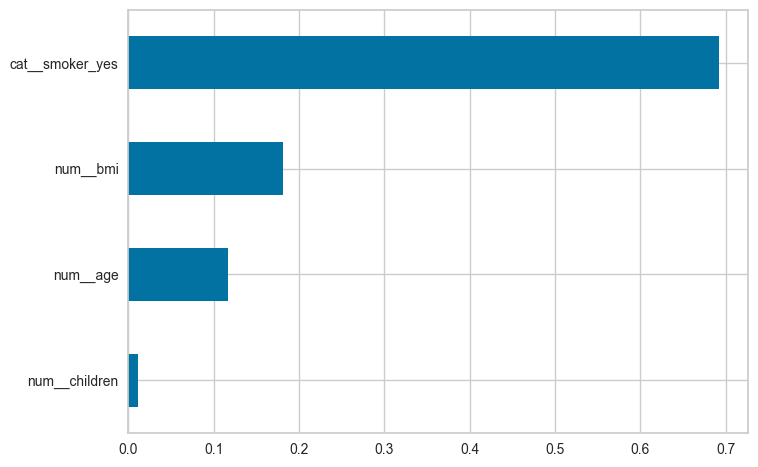

In [124]:
#Plotando series de features e suas importancias
importances = pd.Series(
    data = model_pipeline.named_steps['model'].feature_importances_,
    index = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

importances.sort_values().plot.barh()

In [128]:
with open('./models/model.pkl', 'wb') as file_model : # joblib
    pickle.dump(model_pipeline, file_model)